## Importing Data Libraries

In [1]:
# Import built-in libraries
from collections import defaultdict
from glob import glob
import os
from pathlib import Path
import random
import re
import warnings
from sklearn.preprocessing import MinMaxScaler
# Import third party libraries
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from PIL import Image
import seaborn as sns
from skimage.io import imread
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    classification_report,
    accuracy_score
)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# from sklearn import svm
from sklearn.svm import SVC
import tensorflow as tf

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# Remove warnings
warnings.filterwarnings("ignore")
%matplotlib inline

/Users/adejuwon/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## 1. Function created to find files

In [2]:
def load_rgb_data_cv(path_list, img_size, shuffle=True):
    '''load files in `path_list`, resize them to the square with `img_size`.
    
    Parameters
    ----------
    path_list : list of `path-like`
        list of the paths of png files to convert.
    img_size : int
        Out put image height and width
    shuffle : bool, optional
        If True, shuffle the data

    Raises
    ------
    ValueError
        When path in `png_paths` is not a png file.

    Returns
    -------
    images : numpy.ndarray
       ndarray of images (ndarray with shape (`img_size`, `img_size`, 3)
    labels : numpy.ndarray
       ndarray of labels (the name of the directory containing the image)
    '''    
    data = []

    for path in path_list:
        if path.is_dir():
            raise ValueError('`path_list` contains dir path(s).')
        
        abs_path = path.resolve()  # For clarity
        img = cv2.imread(str(abs_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))

        img_array = np.array(img)  # Convert to ndarray
        label = abs_path.parent.name  # Get parent dir name
        
        data.append([img_array, label])

    if shuffle:
        random.shuffle(data)
    
    data = np.ndarray(data)
    images = data[:, 0]
    labels = data[:, 1]

    return images, labels

In [3]:
def find_files(dir_path, format='png'):
    '''Return a list of Path objects of all files in `dir_path` 
    that have the given extention.
    
    Parameters
    ----------
    dir_path : `str` or `path-like`
        Base image directory, in this particular case, it'd be
        '/Users/adejuwon/MURA-v1.1/valid/XR_HAND/'
    extension : `str`
        string at the end of target file names.

    Raises
    ------
    FileNotFoundError
        When `dir_path` doesn't exist.
    
    Returns
    -------
    list
        list of Path objects of all the png files in the base dir.
    '''
    dir_path = Path(dir_path)
    if not dir_path.exists():
        raise FileNotFoundError('`dir_path` doesn\'t exist')

    # For results
    path_list = []  # To store Paths of png files

    for item in dir_path.iterdir():
        # If the item is a directory, call this function
        if item.is_dir():

            # Skip if the directory name starts with '.', based on
            # `mylistdir` above.
            if item.name.startswith('.'):
                continue

            temp_path_list = find_files(item, format='png')
            path_list.extend(temp_path_list)
            
        # If the item name ends with '.png', add to the list
        elif item.name.endswith(f'.{format}'):
            path_list.append(item)

    return path_list

## 2. Function created to count files in each Directory

In [4]:
def count_files(path_list):
    '''Count how many files are in each of directories.
    Any path in the `path_list` is expected to be:
    1) a file path
    2) direct parent dir is study dir and grand parent is patient dir:
        e.g. '../patient11599/study1_negative/image.png'
    
    Parameters
    ----------
    path_list : list of Path obj
        list of image file paths
    
    Raises
    ------
    ValueError
        1) When `path_list` contains a directory path
        2) When a path in `path_list` is not following the expected dir pattern.
        
    Returns
    -------
    pandas.DataFrame
        df with three columns, `patient_dir`, `study_dir`, and `count`.    
    '''
    count = []
    pattern = re.compile(r'/(?P<patient>patient\d+)/(?P<study>study\d+_\w+)/')
    
    for item in path_list:
        if item.is_dir():
            raise ValueError(
                f'`path_list` contains a directry, supposed to be a file: {item}'
            )

        abs_path = item.resolve()
        m = pattern.search(str(abs_path))
        if m is None:
            raise ValueError(
                'an image file is supposed to be in patient and study directory:',
                f'{abs_path}'
            )
        patient_dir = m.group('patient')
        study_dir = m.group('study')
        count.append([patient_dir, study_dir])

    df = pd.DataFrame(count, columns=['patient_dir', 'study_dir'])
    df = df.groupby(['patient_dir', 'study_dir']).size().reset_index().rename(columns={0: 'count'})  # Rename the column of size
    
    return df

## 3. Function created for Data Statistics: Height , Width and Size of each file

In [5]:
def get_data_stats(path_list, output_path=None):
    '''Read RGB png files, collect stats and return the list of stats.
    Parameters
    ----------
    path_list : list of `path-like`
        list of the paths of RGB png files to convert.
    output_path : str or `path-like`, optional
        Output path to export a csv file, if None, it doesn't save satas.
    Raises
    ------
    TypeError
        When `output_path` is not a str nor path-like
    ValueError
        1) When path in `path_list` is not a png file.
        2) When `path_list` contains non RGB colored file.
    Returns
    -------
    pandas.DataFrame
        dataframe of patient name, filename, width, height, file size (KB)
    '''
    #list structure to collect the statistics
    stats = []
    for path in path_list:
        if path.is_dir():
            raise ValueError('`path_list` contains dir path(s).')
        filename = path.name
        abs_path = path.resolve()
        patient = abs_path.parents[1].name
        study = abs_path.parents[0].name
        size_kb = path.stat().st_size / 1000
        img = plt.imread(path, format='png')
        width = img.shape[0]
        height = img.shape[1]
        stats.append([patient, filename, width, height, size_kb])
    df = pd.DataFrame(stats, columns=['Class','Filename', 'Width', 'Height', 'Size_in_KB'])
    if output_path is not None:
        if not isinstance(output_path, str) and not isinstance(output_path, Path):
            raise TypeError('invalid `output_path`.')
        df.to_csv(output_path)
        print(f'stats saved in {output_path}.')
    return df

In [6]:
def get_data_stats(path_list, output_path=None):
    '''Read RGB png files, collect stats and return the list of stats.
    Parameters
    ----------
    path_list : list of `path-like`
        list of the paths of RGB png files to convert.
    output_path : str or `path-like`, optional
        Output path to export a csv file, if None, it doesn't save satas.
    Raises
    ------
    TypeError
        When `output_path` is not a str nor path-like
    ValueError
        1) When path in `path_list` is not a png file.
        2) When `path_list` contains non RGB colored file.
    Returns
    -------
    pandas.DataFrame
        dataframe of patient name, filename, width, height, file size (KB)
    '''
    #list structure to collect the statistics
    stats = []
    for path in path_list:
        if path.is_dir():
            raise ValueError('`path_list` contains dir path(s).')
        filename = path.name
        abs_path = path.resolve()
        patient = abs_path.parents[1].name
        study = abs_path.parents[0].name
        size_kb = path.stat().st_size / 1000
        img = plt.imread(path, format='png')
        width = img.shape[0]
        height = img.shape[1]
        stats.append([patient, filename, width, height, size_kb])
    df = pd.DataFrame(stats, columns=['Class','Filename', 'Width', 'Height', 'Size_in_KB'])
    if output_path is not None:
        if not isinstance(output_path, str) and not isinstance(output_path, Path):
            raise TypeError('invalid `output_path`.')
        df.to_csv(output_path)
        print(f'stats saved in {output_path}.')
    return df

## Calling the functions  

1. Location of file
2. Number of files 
3. Statistics of each file

In [7]:
# run all the process
base_dir = '/Users/adejuwon/MURA-v1.1/train/XR_HUMERUS/'

# Get the paths of png files
path_list = find_files(base_dir)
# Count files in each directory
count_df = count_files(path_list)
# Get the stats of the files
stats_df = get_data_stats(path_list)



# Load RGB files
#img_size = [224,224]  # put in a correct number
#images, labels = load_rgb_data_cv(path_list, img_size)


In [8]:
stats_df

,Class,Filename,Width,Height,Size_in_KB
0,patient02946,image1.png,511,512,53.571
1,patient02946,image2.png,249,512,36.112
2,patient02713,image1.png,512,420,178.986
3,patient02713,image2.png,512,420,178.392
4,patient03097,image1.png,512,420,150.214
...,...,...,...,...,...
1267,patient03027,image2.png,512,512,37.617
1268,patient02757,image4.png,509,512,49.268
1269,patient02757,image1.png,232,512,33.155
1270,patient02757,image2.png,512,479,47.238


## Scatter and density Plot for Humerus Body part

In [11]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

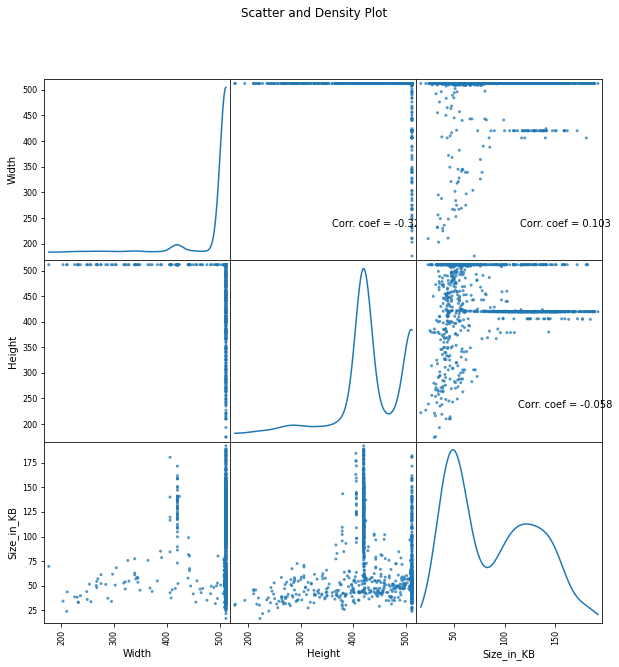

In [12]:
plotScatterMatrix(df2, 10, 10)

## Preprocessing IMAGE using GLCM

In [13]:
PATH="MURA-v1.1/"

In [14]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# train_labeled_studies.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv('/users/adejuwon/MURA-v1.1/train_labeled_studies.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'train_labeled_studies.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 2 columns


In [15]:
dataset_root = Path('/users/adejuwon/MURA-v1.1/')

In [16]:
dataset_root

PosixPath('/users/adejuwon/MURA-v1.1')

In [17]:
list(dataset_root.iterdir())

[PosixPath('/users/adejuwon/MURA-v1.1/valid'),
 PosixPath('/users/adejuwon/MURA-v1.1/.DS_Store'),
 PosixPath('/users/adejuwon/MURA-v1.1/library.py'),
 PosixPath('/users/adejuwon/MURA-v1.1/train_labeled_studies.csv'),
 PosixPath('/users/adejuwon/MURA-v1.1/dataset'),
 PosixPath('/users/adejuwon/MURA-v1.1/valid_image_paths.csv'),
 PosixPath('/users/adejuwon/MURA-v1.1/train'),
 PosixPath('/users/adejuwon/MURA-v1.1/valid_labeled_studies.csv'),
 PosixPath('/users/adejuwon/MURA-v1.1/train_image_paths.csv')]

In [18]:
df=pd.read_csv(dataset_root/'train_image_paths.csv',header=1,names=['filename'])

In [19]:
df.head()

,filename
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [20]:
df['class']=(df.filename.str.extract('study.*_(positive|negative)'))

In [21]:
df.head()

,filename,class
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
2,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive


In [22]:
def generate_df(dataset_root, csv_name):
    df = pd.read_csv(dataset_root/csv_name, header=1, names=['filename'])
    df['class'] = (df.filename
               .str.extract('study.*_(positive|negative)'))
    return df

In [23]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1. / 255)
train_gen = datagen.flow_from_dataframe(generate_df(dataset_root, 'train_image_paths.csv'),
                                        directory=dataset_root.parent,
                                        target_size=(224, 224),
                                        class_mode='binary')
valid_gen = datagen.flow_from_dataframe(generate_df(dataset_root, 'valid_image_paths.csv'),
                                        directory=dataset_root.parent,
                                        target_size=(224, 224),
                                        class_mode='binary')

Found 36807 validated image filenames belonging to 2 classes.
Found 3196 validated image filenames belonging to 2 classes.


In [24]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import imageio as io
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser

In [25]:
train_imgs_path=pd.read_csv(PATH+'train_image_paths.csv')
train_labels=pd.read_csv(PATH+'train_labeled_studies.csv')
valid_imgs_path=pd.read_csv(PATH+'valid_image_paths.csv')
valid_labels=pd.read_csv(PATH+'valid_labeled_studies.csv')

In [26]:
train_imgs_path

,Img_Path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...


In [27]:
all_scans_df = pd.DataFrame(dict(path = glob(os.path.join('MURA-v1.1', '*', '*', '*', '*', '*.png'))))
all_scans_df['TrainSplit'] = all_scans_df['path'].map(lambda x: x.split('/')[-5])
all_scans_df['Region'] = all_scans_df['path'].map(lambda x: x.split('/')[2])
all_scans_df['Patient'] = all_scans_df['path'].map(lambda x: x.split('/')[-3])
all_scans_df['FolderId'] = all_scans_df['path'].map(lambda x: x.split('/')[-2])
all_scans_df['Study'] = all_scans_df['FolderId'].map(lambda x: x.split('_')[0])
all_scans_df['Labels'] = all_scans_df['FolderId'].map(lambda x: x.split('_')[-1] )
all_scans_df.sample(20)

,path,TrainSplit,Region,Patient,FolderId,Study,Labels
6987,MURA-v1.1/train/XR_HAND/patient09813/study1_po...,train,XR_HAND,patient09813,study1_positive,study1,positive
19013,MURA-v1.1/train/XR_ELBOW/patient04923/study1_p...,train,XR_ELBOW,patient04923,study1_positive,study1,positive
25295,MURA-v1.1/train/XR_SHOULDER/patient02035/study...,train,XR_SHOULDER,patient02035,study1_negative,study1,negative
33516,MURA-v1.1/train/XR_WRIST/patient07493/study2_n...,train,XR_WRIST,patient07493,study2_negative,study2,negative
17796,MURA-v1.1/train/XR_ELBOW/patient03609/study1_n...,train,XR_ELBOW,patient03609,study1_negative,study1,negative
21893,MURA-v1.1/train/XR_SHOULDER/patient01684/study...,train,XR_SHOULDER,patient01684,study1_negative,study1,negative
19272,MURA-v1.1/train/XR_ELBOW/patient04978/study1_p...,train,XR_ELBOW,patient04978,study1_positive,study1,positive
26001,MURA-v1.1/train/XR_SHOULDER/patient02691/study...,train,XR_SHOULDER,patient02691,study1_negative,study1,negative
6566,MURA-v1.1/train/XR_HAND/patient10413/study1_ne...,train,XR_HAND,patient10413,study1_negative,study1,negative
33969,MURA-v1.1/train/XR_WRIST/patient07005/study1_p...,train,XR_WRIST,patient07005,study1_positive,study1,positive


In [29]:
train_labels

,Img_Path,Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1
...,...,...
13452,MURA-v1.1/train/XR_HAND/patient11180/study1_ne...,0
13453,MURA-v1.1/train/XR_HAND/patient11181/study1_ne...,0
13454,MURA-v1.1/train/XR_HAND/patient11182/study1_ne...,0
13455,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,0


In [30]:
path_list = find_files(base_dir)

In [31]:
path_list

[PosixPath('/Users/adejuwon/MURA-v1.1/train/XR_HUMERUS/patient02946/study1_negative/image1.png'),
 PosixPath('/Users/adejuwon/MURA-v1.1/train/XR_HUMERUS/patient02946/study1_negative/image2.png'),
 PosixPath('/Users/adejuwon/MURA-v1.1/train/XR_HUMERUS/patient02713/study1_positive/image1.png'),
 PosixPath('/Users/adejuwon/MURA-v1.1/train/XR_HUMERUS/patient02713/study1_positive/image2.png'),
 PosixPath('/Users/adejuwon/MURA-v1.1/train/XR_HUMERUS/patient03097/study1_negative/image1.png'),
 PosixPath('/Users/adejuwon/MURA-v1.1/train/XR_HUMERUS/patient03097/study1_negative/image2.png'),
 PosixPath('/Users/adejuwon/MURA-v1.1/train/XR_HUMERUS/patient02979/study1_negative/image1.png'),
 PosixPath('/Users/adejuwon/MURA-v1.1/train/XR_HUMERUS/patient02979/study1_negative/image2.png'),
 PosixPath('/Users/adejuwon/MURA-v1.1/train/XR_HUMERUS/patient03063/study1_negative/image1.png'),
 PosixPath('/Users/adejuwon/MURA-v1.1/train/XR_HUMERUS/patient03063/study1_negative/image2.png'),
 PosixPath('/Users/a

In [32]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [33]:
# =============================================================================
# resizing, normalization and adaptive histogram equalization to images
# =============================================================================
import skimage.io as io
from skimage.transform import  rescale,resize
from skimage.util import img_as_uint,img_as_ubyte
from skimage.color import rgb2gray
from skimage import exposure
import os
import numpy as np
# =============================================================================
# source and destination dirs
# =============================================================================
#class_name='/Users/adejuwon/MURA-v1.1/'#'covid' or 'normal' or 'pneumonia'
source_dir='Users/adejuwon/MURA-v1.1/valid/train_image.paths.csv'
destination_dir='Users/adejuwon/MURA-v1.1/'
# =============================================================================
# list images list from source dir
# =============================================================================
image_list=path_list# list of images
# =============================================================================
# Normalization and adaptive histogram equalization to each single image
# =============================================================================
for img_name in image_list:
    img=io.imread(os.path.join(source_dir,img_name))
    img_gray = rgb2gray(img)
    img_resized = resize(img_gray, (512, 512))#convert image size to 512*512
    img_rescaled=(img_resized-np.min(img_resized))/(np.max(img_resized)-np.min(img_resized))#min-max normalization 
    img_enhanced=exposure.equalize_adapthist(img_rescaled)#adapt hist
    img_resized_8bit=img_as_ubyte(img_enhanced)
    io.imsave(os.path.join(destination_dir,img_name),img_resized_8bit)#save enhanced image to destination dir



## Preprocess Image using GLCM

In [34]:
# =============================================================================
# feature extraction to create feature pool
# =============================================================================
import skimage.io as io
import scipy.io as sio
from skimage.transform import  rescale,resize
from skimage.util import img_as_uint,img_as_ubyte
from skimage.color import rgb2gray
from skimage import exposure
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
from utils import*


source_dir='Users/adejuwon/MURA-v1.1/valid/train_labeled_studies.csv'
 

# =============================================================================
# start
# =============================================================================
image_list=path_list#list of images

feature_pool=np.empty([1,252])#feature pool
for idx,img_name in enumerate(image_list):
   
    img=io.imread(os.path.join(source_dir,img_name))
    img_rescaled=(img-np.min(img))/(np.max(img)-np.min(img)) 
    
    texture_features=compute_14_features(img_rescaled)#texture features
    
    fft_map=np.fft.fft2(img_rescaled)
    fft_map = np.fft.fftshift(fft_map)
    fft_map = np.abs(fft_map)
    YC=int(np.floor(fft_map.shape[1]/2)+1)
    fft_map=fft_map[:,YC:int(np.floor(3*YC/2))]
    fft_features=compute_14_features(fft_map)#FFT features
    
    wavelet_coeffs = pywt.dwt2(img_rescaled,'sym4')
    cA1, (cH1, cV1, cD1) = wavelet_coeffs
    wavelet_coeffs = pywt.dwt2(cA1,'sym4')
    cA2, (cH2, cV2, cD2) = wavelet_coeffs#wavelet features
    wavelet_features=np.concatenate((compute_14_features(cA1), compute_14_features(cH1),compute_14_features(cV1),compute_14_features(cD1)
    ,compute_14_features(cA2), compute_14_features(cH2),compute_14_features(cV2),compute_14_features(cD2)), axis=0)
    
    
    gLDM1,gLDM2,gLDM3,gLDM4=GLDM(img_rescaled,10)#GLDM in four directions
    gldm_features=np.concatenate((compute_14_features(gLDM1), compute_14_features(gLDM2),
                                  compute_14_features(gLDM3),compute_14_features(gLDM4)), axis=0)
    
    
    glcms =greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])#GLCM in four directions
    glcm_features=np.concatenate((compute_14_features(im2double(glcms[:, :, 0, 0])), 
                                  compute_14_features(im2double(glcms[:, :, 0, 1])),
                                  compute_14_features(im2double(im2double(glcms[:, :, 0, 2]))),
                                  compute_14_features(glcms[:, :, 0, 3])), axis=0)
    
    feature_vector=np.concatenate((texture_features,fft_features,wavelet_features,gldm_features,glcm_features), axis=0).reshape(1,252)#merge to create a feature vector of 252
    feature_pool=np.concatenate((feature_pool,feature_vector), axis=0)


feature_pool=np.delete(feature_pool, 0, 0)


## Extract Features from Files to Correlate Correlation Map and Histogram

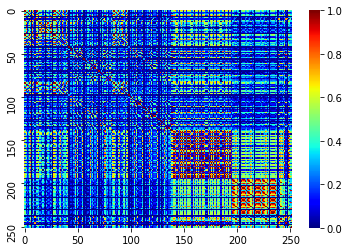

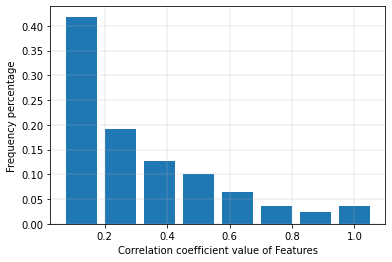

In [35]:
# =============================================================================
# evaluate extracted features files
# =============================================================================
import scipy.io as sio
import os
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc , classification_report
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# =============================================================================
# source dir
# =============================================================================
source_dir='Users/adejuwon/MURA-v1.1/train/train_labeled_studies.csv'

# =============================================================================
# Normalization
# =============================================================================
min_max_scaler=MinMaxScaler()
scores = min_max_scaler.fit_transform(feature_pool) 
# =============================================================================
# correlation map and histogram 
# =============================================================================
df = pd.DataFrame(scores)             
corrMatrix = df.corr().abs().fillna(0)
fig = plt.figure()
sn.heatmap(corrMatrix,xticklabels=50,yticklabels=50,cmap='jet')
plt.savefig('corr_map',dpi=300,format='eps')
# 
fig = plt.figure()
(h,x)=np.histogram(corrMatrix.to_numpy().reshape(1,252*252), bins=8) 
plt.bar(x[1:],h/(252*252),width=0.1)            
plt.grid(linewidth=.3)  
plt.xlabel('Correlation coefficient value of Features')
plt.ylabel('Frequency percentage')
plt.savefig('corr_hist.jpg',dpi=300)

In [36]:
df = stats_df[(stats_df['Width'] <500)]
df

,Class,Filename,Width,Height,Size_in_KB
1,patient02946,image2.png,249,512,36.112
5,patient03097,image2.png,420,512,133.921
20,patient03099,image1.png,420,512,158.550
31,patient02970,image2.png,420,512,135.235
56,patient03039,image1.png,420,512,99.739
...,...,...,...,...,...
1253,patient02750,image2.png,420,512,159.239
1257,patient03212,image2.png,256,512,33.800
1262,patient02902,image1.png,406,512,180.587
1269,patient02757,image1.png,232,512,33.155


In [37]:
stats_df["Width"].min()

176

In [38]:
os.path.join(source_dir,img_name)

'/Users/adejuwon/MURA-v1.1/train/XR_HUMERUS/patient02757/study1_positive/image3.png'

In [39]:
df = stats_df[(stats_df['Height'] >500)]
df2 = df[(df['Width'] < 500)]
df2

,Class,Filename,Width,Height,Size_in_KB
1,patient02946,image2.png,249,512,36.112
5,patient03097,image2.png,420,512,133.921
20,patient03099,image1.png,420,512,158.550
31,patient02970,image2.png,420,512,135.235
56,patient03039,image1.png,420,512,99.739
...,...,...,...,...,...
1253,patient02750,image2.png,420,512,159.239
1257,patient03212,image2.png,256,512,33.800
1262,patient02902,image1.png,406,512,180.587
1269,patient02757,image1.png,232,512,33.155
